# Computational Social Science Project #2 

**Enter your Name:** Sofia Guo

**Group members:** Marisa Tsai, Reiley Reed

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# use random seed for consistent results 
np.random.seed(273)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
#
# Now do the same as above, but for "Obesity_Number"
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 



['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype("int64") 
diabetes['Diabetes_Number']=diabetes['Diabetes_Number'].astype("int64")

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number']=diabetes['Obesity_Number'].astype("int64") 


# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype("int64") 

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype("float")

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]

# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [10]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [11]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1']

In [12]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [13]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

**1. Physcial Inactivity x Diabetes Number**

Based on my basic understanding of diabetes, I plotted each county's proportion of physically inactive people against the proportion of people with diabetes, grouped by region (since physical inactivity is likely correlated with diabetes). I chose to use regions as groups since I know that similar counties are clustered within regions due to their proximities. The plots indicate that there is a positive increasing relationship between physical inactivity and diabetes - counties with higher proportions of physically inactive people tend to have higher rates of diabetes also. This relationship (the slope) seems similar across regions while the density of points differs. Furthermore, in Southern regions there are a lot more counties with higher physical inactivity and diabetes populations compared to Western regions. One takeaway from these graphs is that the Western region has lower average diabetes and physical inactivity levels than the other regions, and the South/Southeast regions have some of the highest average diabetes and physical inactivity levels combined in this sample - the latter regions have counties with higher physical inactivity and correspondingly high diabetes rates.

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


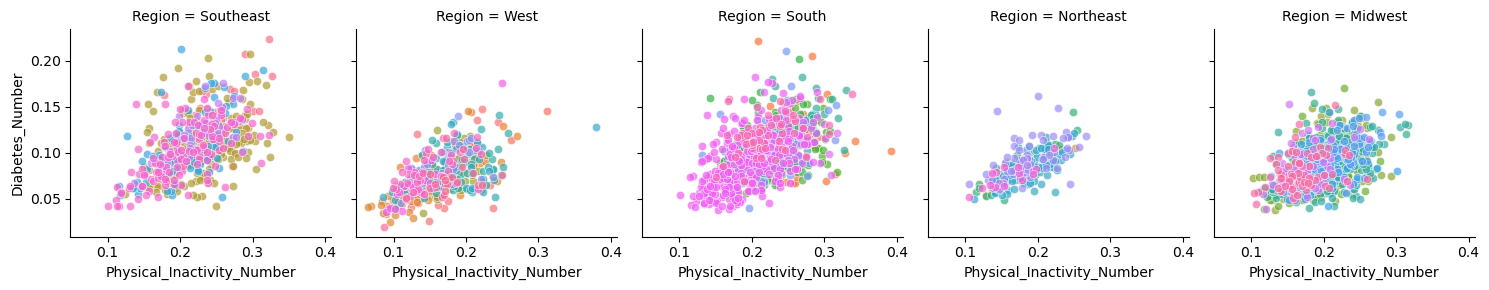

In [18]:
#
# EDA #1 and interpretations in this section 
#-----------

#plot the data
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "Physical_Inactivity_Number", "Diabetes_Number", alpha=.7)

**2. Obesity x Diabetes Number**

I chose to examine obesity and diabetes since I think they also has a strong positive correlation (being physically inactive may make someone more likely to be obese). Confirming my suspicion, the resulting scatterplots seem nearly identical to the previous ones of physical inactivity and diabetes rates. However, is a slight difference in the Southeast, where some counties shift further left on the x axis, indicating lower obesity counts for the same high diabetes counts. This could indicate that counties in this region may have more non-obese populations with diabetes (potentially higher concentration of Type I diabetes which is could be independent of obesity). Interestingly, the Western counties seem to also be more tightly clustered together compared to the first graph. This could indicate that the relationship between obesity and diabetes in western counties is more pronounced; generally, the slopes of these obesity plots seem to vary more between regions. The slope looks slightly steeper (more positive) in the Southeast/South than in the other regions, supporting the hypothesis that the South and Southeast may be of highest concern in terms of targeting diabetes interventions.

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


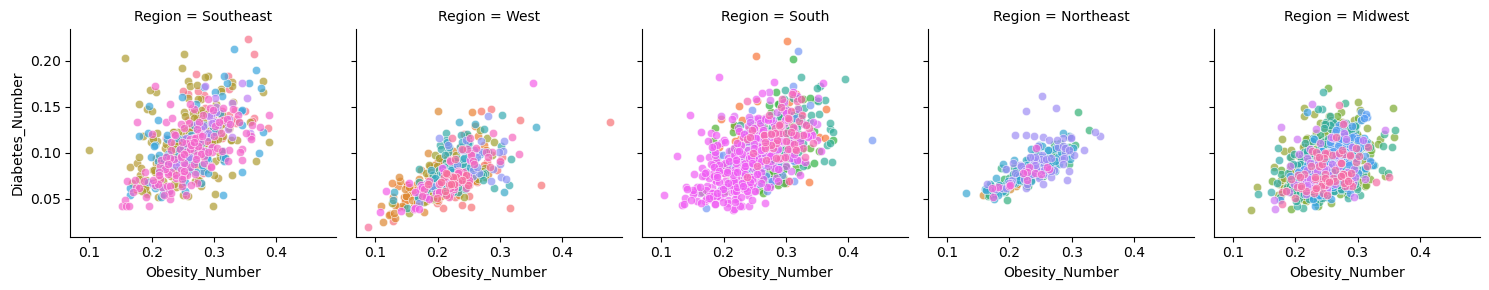

In [19]:
# sns.scatterplot(x='Obesity_Number', y='Diabetes_Number', hue='Region', data=diabetes)
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "Obesity_Number", "Diabetes_Number", alpha=.7)
# g.add_legend()

**Additional plots: by white and Black races**

I added these plots because I was curious whether there was a difference between the racial composistions of regions. That seems to be the case, in addition to the interesting observation that the total population = white and diabetes relationship is slightly negative, especially in the Southeast - for that region, the higher the population of singular race white people, the lower the diabetes rate of the county. There seems to be no relationship in the West and the rest of the regions. There are also many counties with high proportions of singular race white people concentrated in the South, West, Northeast, and Midwest.

Meanwhile, the opposite phenomenon is observed when singular race Black is plotted against diabetes number. Most regions in the US have many counties with low proportions of Black population, especially in the West, Northeast, and Midwest. In contrast, the Southeast has more counties with larger Black populations, and there appears to be a slight positive relationship between the variables - the higher the Black population in a given county in the Southeast is, the higher the diabetes rate tends to be. This relationship is very slight and looks more flat than positive; so it could be that there is no (strong) relationship between the singular race Black variable and diabetes rates.

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


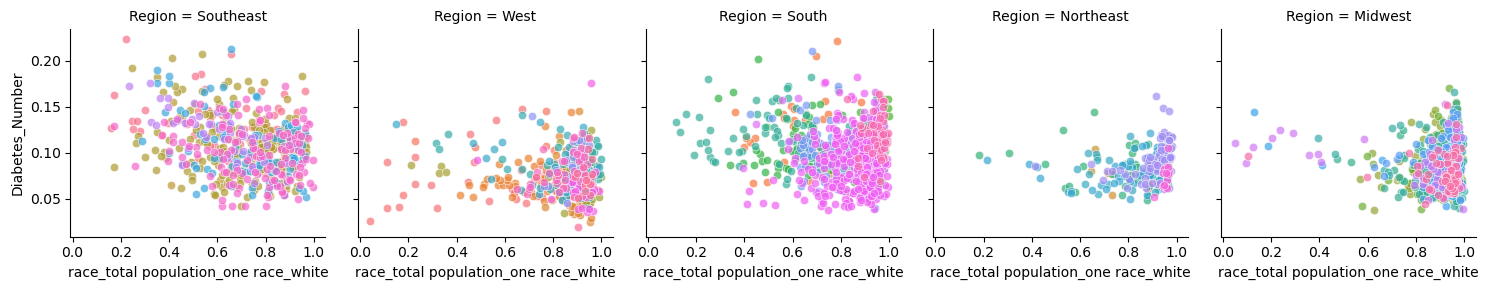

In [21]:
# sns.scatterplot(x='Obesity_Number', y='Diabetes_Number', hue='Region', data=diabetes)
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "race_total population_one race_white", "Diabetes_Number", alpha=.7)
# g.add_legend()

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


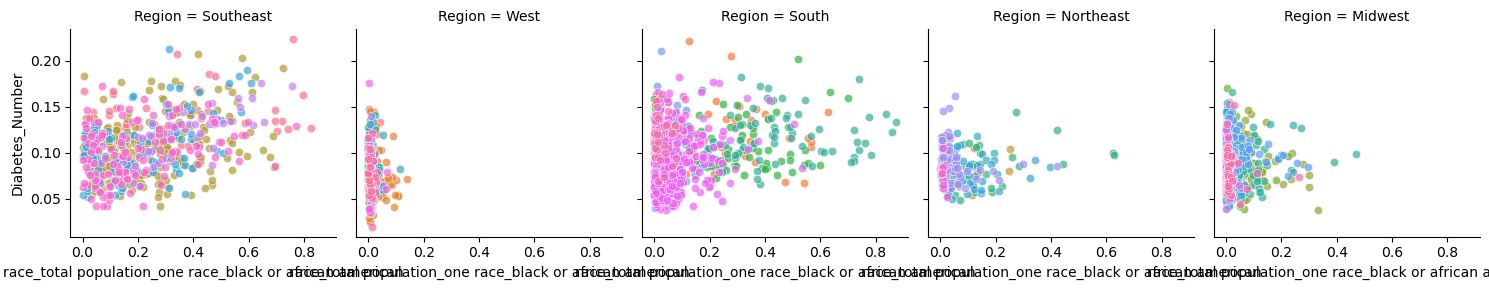

In [17]:
#
# EDA #2 and interpretations in this section 
#-----------
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "race_total population_one race_black or african american", "Diabetes_Number", alpha=.7)

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [22]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [23]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number'],axis=1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In 5.2, I conduct a selection of features which will be detailed below.

In [24]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [25]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,                 # specify training dataset
                                                    y_train,                 # specify test dataset
                                                    train_size=0.75,      # specify proportional split for training
                                                    test_size=0.25)       # specify proportional split for test

In [26]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**

1. Linear Regression: 
    - *Logic and Assumptions:* Ordinary least squares (OLS) minimizes the sum of the squared residuals (distance between the actual observations and the regression line) to describe a relationship between variables. It assumes that the average error is zero, the variance of y is constant over x (residuals are uncorrelated with the independent variable).
    - *Pros:* Very efficient (best linear unbiased estimator) so it can be used on small datasets, and it is easy to implement and interpret coefficients for.
    - *Cons:* Since it is an average of errors among points, it can assign falsely high/low coefficients for the independent variable based on outliers (when the sample size is small). In other words, the smaller the dataset, the more influence a single point has on coefficients ('overfit' for certain variables).
    - *Choice:* Based on our scatter plots of Diabetes_Number and Obesity/Physical inactivity, there seems to be strong positive linear relationships between all three of these variables. Thus, it makes sense to use linear regression as our first model.
    
2. LASSO:
    - *Logic and Assumptions:* LASSO penalizes models with large estimated coefficients when compared to OLS by imposing constraints on the sum of the absolute value of the coefficients (L1 norm).
    - *Pros:* Identifies which features are the least important by shrinking them to zero, similar to removing them.
    - *Cons:* Whichever coefficients that are shrunk depend highly on the sample selected; if there are significant associations between features, the ones that are zeroed out vary from sample to sample (and you wouldn't know because the prediction quality is the same).
    - *Choice:* Given the large size of our sample and the relative consistency across regions of the noted relationships in EDA, it makes sense to use LASSO to see which features are important and mitigate overfitting from OLS.
    
3. Ridge: 
    - *Logic and Assumptions:* Ridge penalizes models with large estimated coefficients when compared to OLS by imposing constraints on the sum of the coefficients squared (L2 norm).
    - *Pros:* Identifies which features are the least important by shrinking them to zero, similar to LASSO; less sensitive to sample idiosyncracies
    - *Cons:* Ridges is less likely to shrink coefficients completely to zero due to the circular coefficient budget compared to LASSO's square; could be bad if significant overfitting is a concern.
    - *Choice:* Given the large size of our sample and the relative consistency across regions of the noted relationships in EDA, it makes sense to use Ridge to see which features are important and mitigate overfitting from OLS.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear Regression 

In [27]:
#
# Model 1 training
#-----------
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)


#### Model 2:  LASSO

In [28]:
#
# Model 2 training
#-----------
# create and fit the model
lasso_reg = Lasso(max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


#### Model 3:  Ridge

In [29]:
#
# Model 3 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [30]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

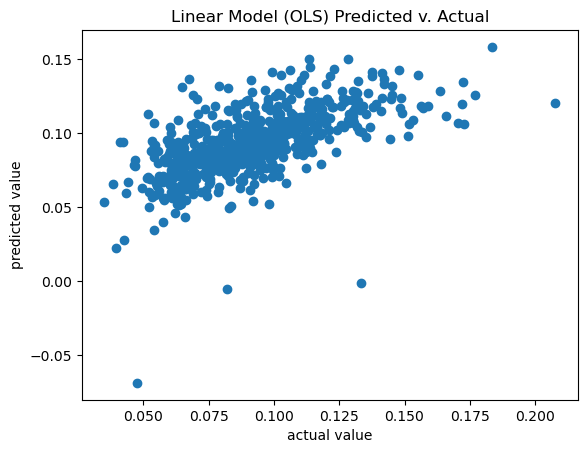

In [31]:
# using the validation dataset and the trained model, predict the number of riders 
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

In [32]:
# calculate root mean squared errror
rmse(lin_pred,     # specify predicted values 
     y_validate)   # specify actual values values

0.02130238997665878

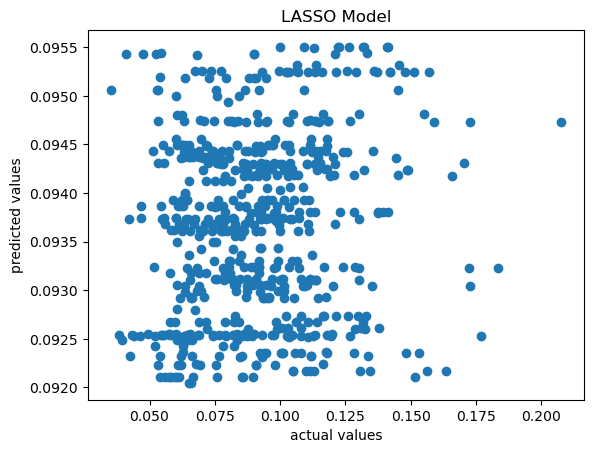

In [33]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [34]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

0.026013508613541243

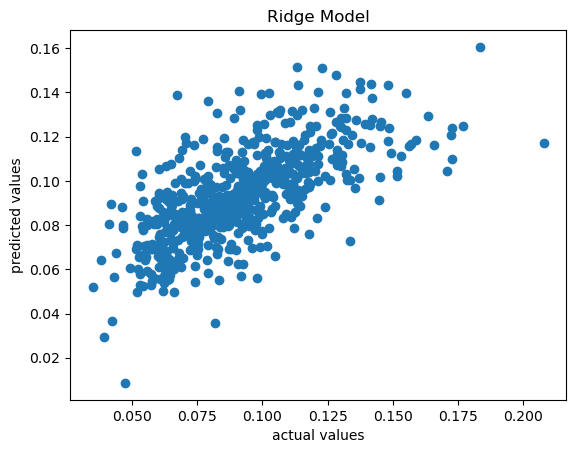

In [35]:
#
# Predict on validation data
#-----------
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()


In [36]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

0.01962124876820703

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

**Below I select features that have a coefficient greater than 0.001 to reduce the feature count from 92 to 61; this presumably takes more important features (those who have higher coefficients).**

In [37]:
# Our best performing model is Ridge, so we will choose the top 50 out of 90 features that have
# the largest coefficients by absolute value

# take the absolute value of the ridge regression coefficients
ridge_reg_data['Coefficient'] = ridge_reg_data['Coefficient'].abs()

# select the top features with the largest coefficients by absolute magnitude
top_preds = ridge_reg_data[ridge_reg_data['Coefficient'] > 0.001].sort_values('Coefficient', ascending=False)

#extract the array of top predictor col names
names_top=top_preds['Feature'].values

In [38]:
# retrain the model using our selected features
# first filter X for the selected features from names_top
X=X[names_top]

In [77]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [78]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,                 # specify training dataset
                                                    y_train,                 # specify test dataset
                                                    train_size=0.75,      # specify proportional split for training
                                                    test_size=0.25)       # specify proportional split for test

In [79]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

In [80]:
#
# Model 3 retraining
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


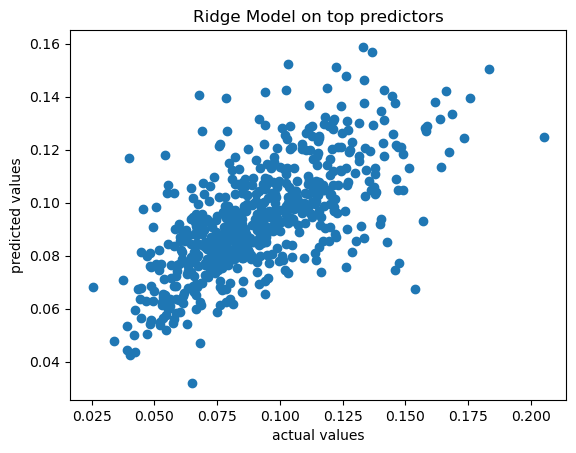

In [81]:
#
# Predict on test data
#-----------
# use the model to make predictions
ridge_pred = ridge_model.predict(X_test)

# plot the predictions
plt.scatter(y_test, ridge_pred)
plt.title('Ridge Model on top predictors')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()


In [82]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_test)

0.020672933660452572

### 5.3 Implement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [83]:
#
# Run cross-validation
#-----------

#
# RIDGE 
#-----------
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_test)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Validation RMSE', rmse(best_ridge_pred, y_test))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


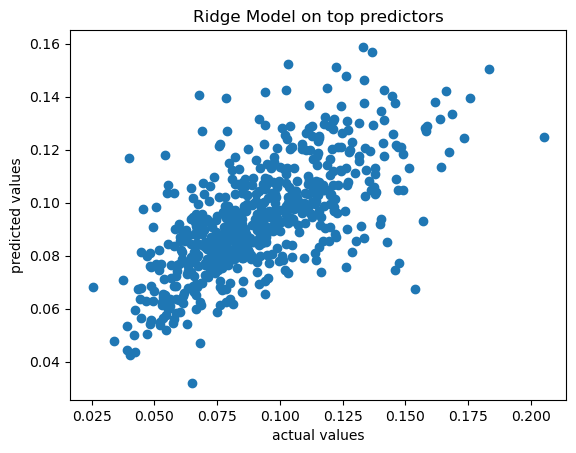

In [84]:
#
# Predict on test data
#-----------
# use the model to make predictions
ridge_pred = ridge_model.predict(X_test)

# plot the predictions
plt.scatter(y_test, ridge_pred)
plt.title('Ridge Model on top predictors')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()


In [86]:
#append predictions to X_test
X_test['Ridge Predictions'] = ridge_pred.tolist()
X_test['y_test'] = y_test.tolist()

X_test

,race alone or in combination with one or more other races_total population_asian,sex and age_total population_65 years and over_female,sex and age_total population_65 years and over_male,Obesity_Number,Region_Southeast,Physical_Inactivity_Number,Region_South,race_total population_one race_some other race,hispanic or latino and race_total population_not hispanic or latino_asian alone,race_total population_two or more races_white and american indian and alaska native,race_total population_one race_white,race_total population_one race_asian,race_total population_one race_black or african american,race_total population_one race_asian_chinese,race alone or in combination with one or more other races_total population_some other race,sex and age_total population_16 years and over,race alone or in combination with one or more other races_total population_american indian and alaska native,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,sex and age_total population_sex ratio (males per 100 females),race_total population_one race_asian_filipino,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,Region_Northeast,race_total population_one race_american indian and alaska native,race_total population_one race_asian_other asian,race_total population_one race_asian_japanese,race_total population_one race_asian_asian indian,sex and age_total population_65 years and over_sex ratio (males per 100 females),sex and age_total population_18 years and over_female,sex and age_total population_21 years and over,Region_West,sex and age_total population_65 to 74 years,sex and age_total population_18 years and over_sex ratio (males per 100 females),hispanic or latino and race_total population_not hispanic or latino_white alone,citizen - voting age population_citizen - 18 and over population_male,sex and age_total population_under 5 years,race_total population_one race,race_total population_two or more races,sex and age_total population_5 to 9 years,sex and age_total population_85 years and over,sex and age_total population_18 years and over_male,sex and age_total population_20 to 24 years,sex and age_total population_female,sex and age_total population_male,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races,race_total population_two or more races_white and asian,hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,race_total population_one race_asian_korean,sex and age_total population_median age (years),race_total population_two or more races_white and black or african american,citizen - voting age population_citizen - 18 and over population,race_total population_one race_asian_vietnamese,race_total population_one race_american indian and alaska native_sioux tribal grouping,race alone or in combination with one or more other races_total population_black or african american,sex and age_total population_65 years and over,race_total population_one race_american indian and alaska native_cherokee tribal grouping,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_hispanic or latino (of any race),sex and age_total population_55 to 59 years,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,Ridge Predictions,y_test
2138,-0.330697,-0.397170,-0.490614,1.349851,False,0.710118,True,0.222419,-0.360924,2.891410,-1.280579,-0.362495,-0.469029,-0.253658,0.259265,-0.807507,3.308266,-0.461516,0.757617,-0.034888,0.199186,False,3.040882,-0.440411,-0.215362,-0.366327,-0.379150,-1.429441,-0.726678,False,-0.548596,0.803671

In [117]:
# identify non-dichotomous columns we want to keep as id's
cont_cols = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

#melt the regions back into one column for grid plotting
x_melted = pd.melt(X_test, id_vars=cont_cols)

x_melted_final = x_melted.loc[x_melted['value'] == True] #drops all the false values (drops more than half)

,race alone or in combination with one or more other races_total population_asian,sex and age_total population_65 years and over_female,sex and age_total population_65 years and over_male,Obesity_Number,Physical_Inactivity_Number,race_total population_one race_some other race,hispanic or latino and race_total population_not hispanic or latino_asian alone,race_total population_two or more races_white and american indian and alaska native,race_total population_one race_white,race_total population_one race_asian,race_total population_one race_black or african american,race_total population_one race_asian_chinese,race alone or in combination with one or more other races_total population_some other race,sex and age_total population_16 years and over,race alone or in combination with one or more other races_total population_american indian and alaska native,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,sex and age_total population_sex ratio (males per 100 females),race_total population_one race_asian_filipino,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,race_total population_one race_american indian and alaska native,race_total population_one race_asian_other asian,race_total population_one race_asian_japanese,race_total population_one race_asian_asian indian,sex and age_total population_65 years and over_sex ratio (males per 100 females),sex and age_total population_18 years and over_female,sex and age_total population_21 years and over,sex and age_total population_65 to 74 years,sex and age_total population_18 years and over_sex ratio (males per 100 females),hispanic or latino and race_total population_not hispanic or latino_white alone,citizen - voting age population_citizen - 18 and over population_male,sex and age_total population_under 5 years,race_total population_one race,race_total population_two or more races,sex and age_total population_5 to 9 years,sex and age_total population_85 years and over,sex and age_total population_18 years and over_male,sex and age_total population_20 to 24 years,sex and age_total population_female,sex and age_total population_male,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races,race_total population_two or more races_white and asian,hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,race_total population_one race_asian_korean,sex and age_total population_median age (years),race_total population_two or more races_white and black or african american,citizen - voting age population_citizen - 18 and over population,race_total population_one race_asian_vietnamese,race_total population_one race_american indian and alaska native_sioux tribal grouping,race alone or in combination with one or more other races_total population_black or african american,sex and age_total population_65 years and over,race_total population_one race_american indian and alaska native_cherokee tribal grouping,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_hispanic or latino (of any race),sex and age_total population_55 to 59 years,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,Ridge Predictions,y_test,variable,value
1,-0.242607,-0.206148,-0.188188,0.712662,1.916199,-0.258565,-0.170480,-0.391845,-0.629893,-0.175558,1.134684,-0.411783,-0.313258,0.458136,-0.295865,1.150401,0.019568,-0.089544,-0.200666,-0.229866,-0.252773,-0.215362,0.327357,-0.019010,0.232051,0.476207,-0.004826,-0.049777,-0.206518,0.314079,-0.424984,0.801596,-0.801596,-1.358276,-0.346783,

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


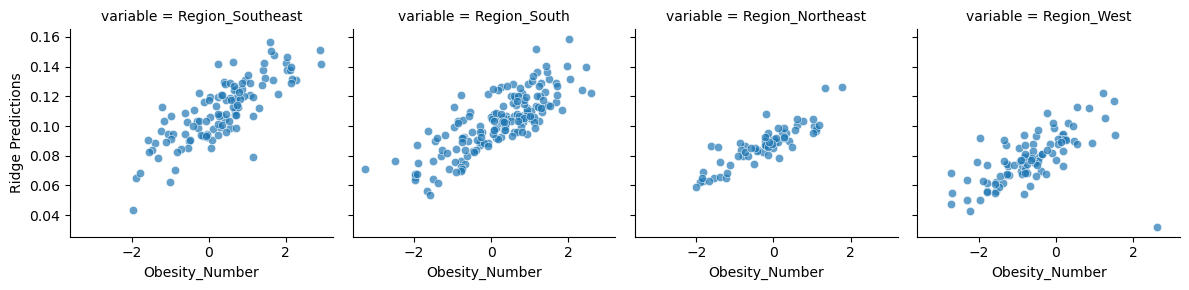

In [118]:
# sns.scatterplot
g = sns.FacetGrid(x_melted_final, col="variable")
g.map(sns.scatterplot, "Obesity_Number","Ridge Predictions", alpha=.7)

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


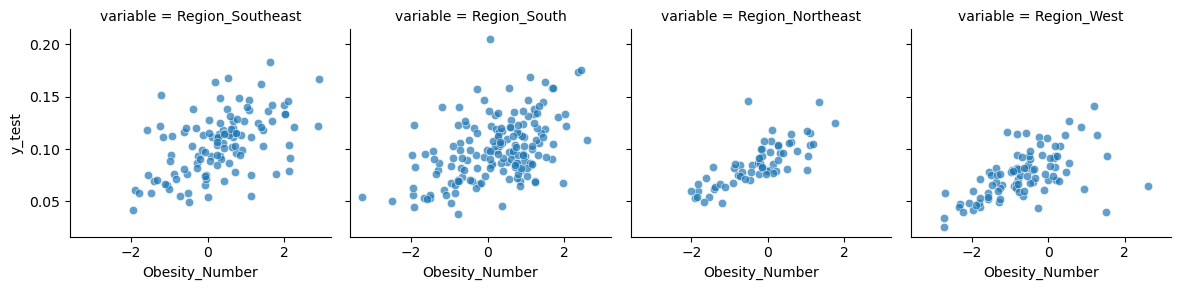

In [121]:
# sns.scatterplot
g = sns.FacetGrid(x_melted_final, col="variable")
g.map(sns.scatterplot, "Obesity_Number","y_test", alpha=.7)

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


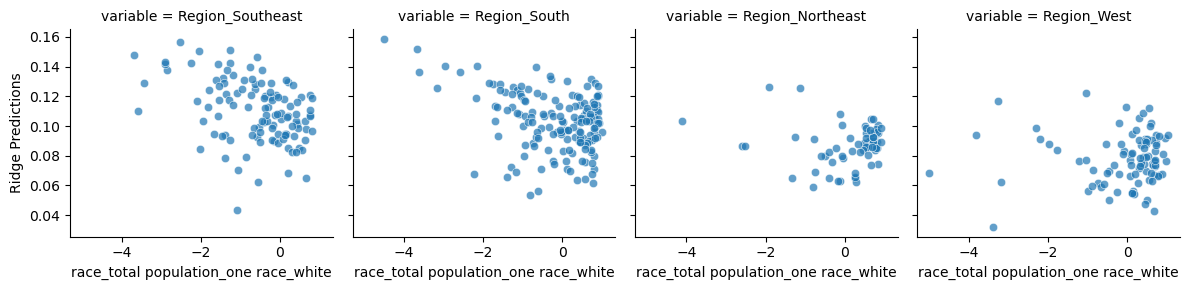

In [122]:
# sns.scatterplot
g = sns.FacetGrid(x_melted_final, col="variable")
g.map(sns.scatterplot, "race_total population_one race_white","Ridge Predictions", alpha=.7)

/Users/sofia/miniconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


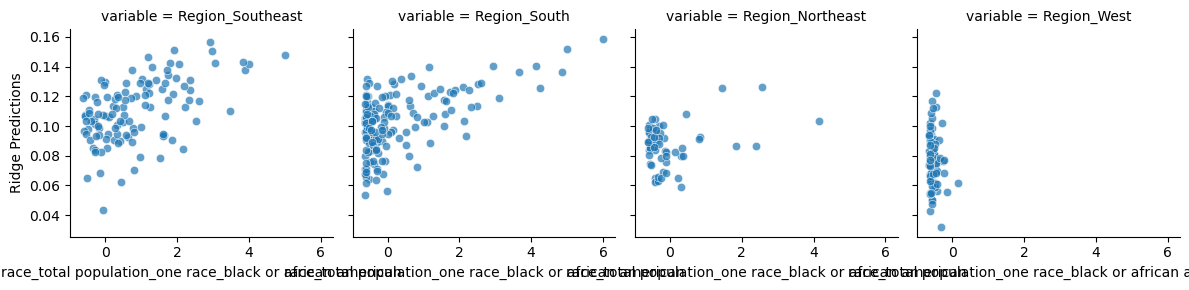

In [123]:
# sns.scatterplot
g = sns.FacetGrid(x_melted_final, col="variable")
g.map(sns.scatterplot, "race_total population_one race_black or african american","Ridge Predictions", alpha=.7)

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**The bias variance tradeoff describes the two components of mean squared error (MSE); variance refers to the differences across samples/datasets, and bias refers to the differences between the expected predicted value and the actual value. The tradeoff is relevant to machine learning because OLS assumes there is no bias but machine learning can amplify biases in the training data.**

2. Define overfitting, and why it matters for machine learning. How can we address it?

**Overfitting refers to when the model learned the relationships between features and the outcome too strongly on the training data, so it imposes those relationships on test samples even when they are not similar. Overfitting is undesirable in policy questions like this one because our intervention is intended to accurately prioritize areas where diabetes prevention is most needed. If the training data misleads the ML algorithm to overrepresent the strength of a relationship because of the idiosyncracies of the sample (for example, between certain racial groups and diabetes occurrence), the predictions would mistakenly direct resources to areas that may not actually need the intervention as much (and divert the pilot resources away from areas who do need the intervention).**

**Cross validation is one way to combat overfitting, which splits the data into k-folds and estimates the model k times using each fold as the test data - then averages the measure of mean error and chooses the model with the best average prediction quality. In this case we utilize 3-fold CV and find that the best model has the same RMSE (~0.02) as the non-validated Ridge model.**

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**After fitting the Ridge model on the test data, I graphed the predictions using a measure that is consistently correlated across regions (Obesity_Number) to compare which regions had the highest predicted diabetes proportions. I also graphed the same feature, Obesity_Number, against the test set actual values for diabetes rates. Consistent with initial EDA, the South and Southwest regions appear to have the highest predicted diabetes rates. In addition, one can clearly observe the overfitting effects that the model has on the test data; there is much more spread in the actual values than there is in the predicted values for each region (except for the West, which seems to have equal spread in both predicted and actual values). Based on this information, I would prioritize the South and Southeast regions for the pilot program due to their higher predicted diabetes incidence.**

**My answer would very likely change if I took race, gender, age, and other factors into account - for example, there is clearly a difference of diabetes incidence between Black and white populations, which vary in their concentrations across regions. I would want to take into account the equity of my pilot and ensure that I am not making policy decisions without being aware of the distributional inequities that underlie the data. I would not be very confident in deploying this model in the real world because I would be very worried that I am not understanding the underlying causal mechanism well. If I don't understand the mechanisms (or nuances of the counties/regions, their particular needs/constraints), I would be at risk of recommending policy measures that fundamentally do not treat the intended measure. It would be more ethical to use this tool as a guidance or exploratory measure first, along with deeper knowledge experts from each county to modify, guide, and implement appropriate final policies.**